# myChess Tagger

This notebook contains the implementation for our tagger.

Because this is mostly a proof of concept, the notebook paradigm seems best suited to explaining methodology as it occurs.
It would not be difficult to recompile this to a standalone .py file for deployment in a production environment.


We can begin by importing necessary libraries.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd

C:\Users\Bill\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Bill\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


We can then import our data sets and begin necessary preprocessing like cleaning.

In [2]:
aggro = pd.read_csv("aggressive.csv")
defen = pd.read_csv("defensive.csv")

We can see that our defensive data set is slightly larger than our aggressive data set, but it is not too large of a difference.

In [3]:
print(len(aggro))
print(len(defen))

11118
11573


In [4]:
print(aggro.head())

        Event Site        Date Round                White  \
0  Earl tourn    ?  1906.??.??     ?               Savrov   
1  Earl tourn    ?  1906.??.??     ?                Giese   
2  Earl tourn    ?  1906.??.??     ?  Alekhine, Alexander   
3  Earl tourn    ?  1906.??.??     ?  Alekhine, Alexander   
4  Earl tourn    ?  1906.??.??     ?            Manko, V.   

                 Black  Result  BlackElo  WhiteElo  ECO  Move Count  \
0  Alekhine, Alexander     0-1       NaN       NaN  C30          44   
1  Alekhine, Alexander     0-1       NaN       NaN  C47          17   
2         Ljubimov, T.  Jan-00       NaN       NaN  C58          38   
3           Romaskevic  Jan-00       NaN       NaN  C20          18   
4  Alekhine, Alexander  Jan-00       NaN       NaN  C52          35   

   Average Material Threatened  Gambit Count  Check Count  \
0                     1.840909             0            8   
1                     1.235294             0            1   
2                     1

We can then drop data elements that won't be useful for training purposes and encode the ECO field.

ECO represents the opener that occurred for the game in question, and so we choose to encode this to get an idea of what openers occur in aggressive and defensive players' games respectively.

After dropping and enconding we can begin train/test splitting.

In [5]:
total = pd.concat([aggro, defen])
drops = ["Black", "BlackElo", "BlackTeam", "BlackTeamCountry", "Date", "Event", 
         "EventCategory", "EventCountry", "EventDate", "EventRounds", "EventType", "FEN", "PlyCount", "Result",
        "Round", "SetUp", "Site", "Source", "SourceDate", "White", "WhiteElo", "WhiteTeam", "WhiteTeamCountry"]
total = total.drop(drops, axis=1)

number = LabelEncoder()
total["ECO"] = number.fit_transform(total["ECO"].astype('str'))
print(total.columns)

Index(['Aggressive', 'Average Board Evaluation', 'Average Material Threatened',
       'Check Count', 'ECO', 'Gambit Count', 'Move Count'],
      dtype='object')


In [6]:
X = total.drop(["Aggressive"], axis=1)
y = total["Aggressive"]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

The cells below are mostly for testing purposes to achieve some satisfactory number of decision trees in our forest. Usually the more the better but for the sake of this application we can stop at some low number (i.e. 200 or less), especially since the accuracy doesn't fluctuate too much after a certain point.

In [7]:
scores = []
classifiers = []
nmin = 1
nmax = 200
for n in range(nmin, nmax):
    forest = RandomForestClassifier(n_estimators = n)
    forest.fit(X_train, y_train)
    classifiers.append(forest)
    scores.append(forest.score(X_test, y_test))

In [8]:
amax = np.argmax(scores)
print(scores[amax])

0.6811323274135399


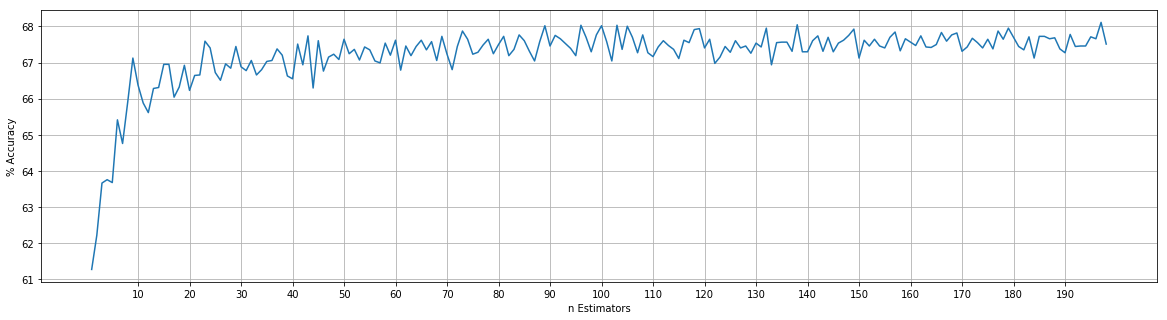

In [19]:
x = np.array([i for i in range(nmin, nmax-1)])
scores = np.array(scores)

plt.figure(figsize=(20,5));
plt.plot(x, [r * 100 for r in [scores[i] for i in x]]);
plt.xticks([i for i in x if i % 10 == 0])
plt.grid(True)
plt.ylabel("% Accuracy")
plt.xlabel("n Estimators")
plt.show();

In [ ]:
print("The best number of trees from our trials: ", amax)
print("The accuracy achieved with that number of trees:" , scores[amax])

The following method, provided <a href="http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html">here,</a> gives us a convenient means of plotting our confusion matrices.

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2724 1088]
 [1299 2378]]
Normalized confusion matrix
[[0.71 0.29]
 [0.35 0.65]]


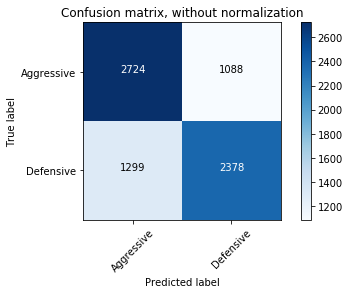

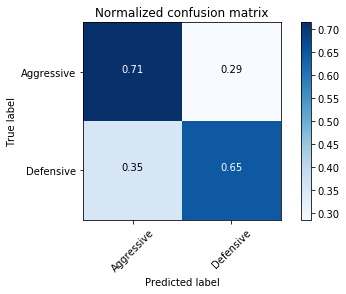

In [12]:
f = classifiers[amax]
y_pred = f.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Aggressive", "Defensive"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Aggressive", "Defensive"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

We can then begin to examine cross validation accuracy.

In [13]:
cvscore = cross_val_score(f, X_train, y_train, cv=10)
print(np.mean(cvscore))

0.6655715298430043


Lastly, we can briefly examine some configurations via Grid Search to see what performance and accuracy may be possible under certain conditions for our classifier.

In [14]:
clf = RandomForestClassifier(n_jobs=-1)
arr = [i*5 for i in range(1, 20)]
param_grid = {
    'n_estimators': arr, # up to 100 trees
    'max_depth': arr,
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X_train, y_train)
print(grid_clf.best_params_)
print(grid_clf.grid_scores_)

{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 85}
[mean: 0.61854, std: 0.01071, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 5}, mean: 0.61696, std: 0.00877, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10}, mean: 0.62143, std: 0.01162, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 15}, mean: 0.62209, std: 0.01461, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 20}, mean: 0.62472, std: 0.01245, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 25}, mean: 0.62248, std: 0.01319, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 30}, mean: 0.62400, std: 0.01287, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 35}, mean: 0.62387, std: 0.01306, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 40}, mean: 0.62262, std: 0.01092, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 45}, mean: 0.62472, std: 0.01018, params: {'max_dept

In [15]:
print(grid_clf.best_params_)
print(grid_clf.grid_scores_)

{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 85}
[mean: 0.61854, std: 0.01071, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 5}, mean: 0.61696, std: 0.00877, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10}, mean: 0.62143, std: 0.01162, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 15}, mean: 0.62209, std: 0.01461, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 20}, mean: 0.62472, std: 0.01245, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 25}, mean: 0.62248, std: 0.01319, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 30}, mean: 0.62400, std: 0.01287, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 35}, mean: 0.62387, std: 0.01306, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 40}, mean: 0.62262, std: 0.01092, params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 45}, mean: 0.62472, std: 0.01018, params: {'max_dept

In [16]:
f = grid_clf.best_estimator_
print(f.score(X_test, y_test))

0.6737882227266658
